# Vehicle Re-Id

* dataset: vehicle-776
* model: CNN addestrata tramite Contrastive Loss

## 1. Download datasets

In [ ]:
# Monto il mio google drive (una volta montanto il contenuto di google drive sarà accessibile nella directory `/content/drive/My Drive`)
from google.colab import drive
!mkdir -p drive/
drive.mount("/content/drive")

In [2]:
# Indoviduo il path del dataset
dataset_path = "/content/drive/MyDrive/datasets/VeRi.zip"

In [3]:
# Creo la cartella `data`
!mkdir -p data/

In [4]:
# Copio il file nel Workspace
!cp "/content/drive/MyDrive/datasets/VeRi.zip" /content/

In [5]:
# Controllo il tipo di file scaricato
!file VeRi.zip

VeRi.zip: Zip archive data, at least v1.0 to extract, compression method=store


In [6]:
# Decomprimo il file zip
!unzip -q /content/VeRi.zip -d data

## 2. Organizzazione Dataset

Parsing del file XML

Estraiamo le informazioni rilevanti dai file XML:

* train_labels_df
* test_labels_df

Le memorizzo in un DataFrame Pandas che contengono:

* nome immagine
* Vehicle ID
* Camera ID
* Color ID
* Type ID



In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_labels(label_path):
    # Lista per memorizzare i dati
    data = []

    # Aprire il file con la codifica esplicita
    with open(label_path, "r", encoding="ascii", errors="ignore") as f:
      content = f.read() # Leggi il contenuto ignorando gli errori

      try:
        tree = ET.ElementTree(ET.fromstring(content))  # Parso direttamente il contenuto
        root = tree.getroot()  # Ottieni il nodo radice
        # Iterare attraverso i nodi Item
        for item in root.find("Items").findall("Item"):
          image_name = item.get("imageName")
          vehicle_id = item.get("vehicleID")
          camera_id = item.get("cameraID")
          color_id = item.get("colorID")
          type_id = item.get("typeID")

          # Aggiungere i dati alla lista
          data.append({
            "image_name": image_name,
            "vehicle_id": int(vehicle_id),
            "camera_id": camera_id,
            "color_id": int(color_id),
            "type_id": int(type_id)
          })
      except ET.ParseError as e:
        print(f"Errore di parsing: {e}")
        return {}

    return pd.DataFrame(data)

# Percorso al file XML
train_label_path = "./data/VeRi/train_label.xml"
test_label_path = "./data/VeRi/test_label.xml"

# Creo un dataframe per le immagini di train e test
train_labels_df = parse_labels(train_label_path)
test_labels_df = parse_labels(test_label_path)

# Recupero le dimensioni dei dataset (righe e colonne)
train_df_rows, train_df_cols = train_labels_df.shape
test_df_rows, test_df_cols = test_labels_df.shape

print(f"train dataframe: righe: {train_df_rows}, colonne: {train_df_cols}")
print(f"test dataframe: righe: {test_df_rows}, colonne: {test_df_cols}")

train dataframe: righe: 37746, colonne: 5
test dataframe: righe: 11579, colonne: 5


In [40]:
# Controlliamo i primi elementi per confermare che le colonne siano riempite correttamente
print(train_labels_df.head())
print(test_labels_df.head())

                 image_name  vehicle_id camera_id  color_id  type_id
0  0001_c001_00016450_0.jpg           1      c001         1        4
1  0001_c001_00016460_0.jpg           1      c001         1        4
2  0001_c001_00016470_0.jpg           1      c001         1        4
3  0001_c001_00016480_0.jpg           1      c001         1        4
4  0001_c001_00016490_0.jpg           1      c001         1        4
                 image_name  vehicle_id camera_id  color_id  type_id
0  0002_c002_00030600_0.jpg           2      c002         1        4
1  0002_c002_00030605_1.jpg           2      c002         1        4
2  0002_c002_00030615_1.jpg           2      c002         1        4
3  0002_c002_00030625_1.jpg           2      c002         1        4
4  0002_c002_00030640_0.jpg           2      c002         1        4


In [41]:
# Controlliamo che non ci siano valori nulli (stampa quanti NULL ci sono)
print(train_labels_df.isnull().sum())
print(test_labels_df.isnull().sum())

image_name    0
vehicle_id    0
camera_id     0
color_id      0
type_id       0
dtype: int64
image_name    0
vehicle_id    0
camera_id     0
color_id      0
type_id       0
dtype: int64


In [42]:
print("Color ID unici:", train_labels_df["color_id"].nunique())
print("Type ID unici:", train_labels_df["type_id"].nunique())

Color ID unici: 10
Type ID unici: 9


## 3. Creazione e gestione delle coppie per l'allenamento della rete 
Devo creare coppie di immagini (chiamate positive e negative) per la rete siamese:
* Coppie positive: Immagini dello stesso veicolo (stesso id_veicolo).
* Coppie negative: Immagini di veicoli diversi (differenti id_veicolo).

Le coppie generate hanno formato (img1, img2, label) dove label è 1 per le coppie positive o 0 per le coppie negative

In [ ]:
import pandas as pd
import random

def create_limited_pairs(dataframe, negative_ratio=1.0, max_pairs=300000):
    """
    Genera coppie di immagini con un numero limitato e un rapporto specificato tra coppie positive e negative.

    Args:
        dataframe (pd.DataFrame): Contiene colonne ['image_name', 'vehicle_id'].
        negative_ratio (float): Numero di coppie negative generate per ogni coppia positiva.
        max_pairs (int): Numero massimo totale di coppie (positive + negative).

    Returns:
        List[Tuple]: Lista di tuple (img1, img2, label), dove label è 1 per coppie positive e 0 per negative.
    """
    data_by_id = dataframe.groupby('vehicle_id')
    unique_ids = list(data_by_id.groups.keys())

    pairs = []
    positive_pairs = []
    
    # Genera tutte le coppie positive
    for vehicle_id in unique_ids:
        images = data_by_id.get_group(vehicle_id)["image_name"].values
        for i in range(len(images)):
            for j in range(i + 1, len(images)):
                positive_pairs.append((images[i], images[j], 1))

    # Se ci sono troppe coppie positive, ne prendiamo solo una parte
    num_positive = min(len(positive_pairs), max_pairs // 2)
    positive_pairs = random.sample(positive_pairs, num_positive)

    # Genera un numero di coppie negative bilanciato
    num_negative = min(int(num_positive * negative_ratio), max_pairs - num_positive)
    negative_pairs = set()

    while len(negative_pairs) < num_negative:
        vehicle_id_1, vehicle_id_2 = random.sample(unique_ids, 2)
        img1 = random.choice(data_by_id.get_group(vehicle_id_1)["image_name"].values)
        img2 = random.choice(data_by_id.get_group(vehicle_id_2)["image_name"].values)
        negative_pairs.add((img1, img2, 0))

    # Unisce coppie positive e negative
    pairs = positive_pairs + list(negative_pairs)
    random.shuffle(pairs)  # Mischia le coppie per evitare bias

    return pairs

# Genera coppie limitate a 300k nel train e 100k nel test
train_pairs = create_limited_pairs(train_labels_df, negative_ratio=1.0, max_pairs=750000)
test_pairs = create_limited_pairs(test_labels_df, negative_ratio=1.0, max_pairs=150000)

# Conta le coppie generate
train_num_positive = sum(1 for _, _, label in train_pairs if label == 1)
train_num_negative = sum(1 for _, _, label in train_pairs if label == 0)

test_num_positive = sum(1 for _, _, label in test_pairs if label == 1)
test_num_negative = sum(1 for _, _, label in test_pairs if label == 0)

print(f"Numero di coppie del train: {len(train_pairs)}: {train_num_positive} positive, {train_num_negative} negative")
print(f"Numero di coppie del test: {len(test_pairs)}: {test_num_positive} positive, {test_num_negative} negative")


Numero di coppie del train: 750000: 375000 positive, 375000 negative
Numero di coppie del test: 150000: 75000 positive, 75000 negative


In [ ]:
import torch
from PIL import Image
import os
from torch.utils.data import Dataset

class SiamesePairDataset(Dataset):
    def __init__(self, pairs, image_dir, transform=None):
        """
        Dataset per coppie siamese.

        Args:
            pairs (list): Lista di tuple (img1, img2, label).
            image_dir (str): Directory delle immagini.
            transform (callable, optional): Trasformazioni per le immagini.
        """
        self.pairs = pairs
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_name, img2_name, label = self.pairs[idx]
        img1_path = os.path.join(self.image_dir, img1_name)
        img2_path = os.path.join(self.image_dir, img2_name)

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [61]:
from torchvision import transforms

# Trasformazioni per l'allenamento
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip orizzontale con probabilità 0.5
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variazione di colore
    transforms.RandomRotation(degrees=15),  # Rotazione casuale fino a 15 gradi
    transforms.ToTensor(),  # Converte l'immagine in un tensore
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])

# Trasformazioni per il test
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # Converte l'immagine in tensore
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalizzazione
])

In [ ]:
from torch.utils.data import DataLoader

# Configura il DataLoader
train_dataset = SiamesePairDataset(train_pairs, image_dir="./data/VeRi/image_train", transform=train_transform)
test_dataset = SiamesePairDataset(test_pairs, image_dir="./data/VeRi/image_test", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 4. Definizione del modello
Il modello `LightCnnNetwork` è una rete convoluzionale (CNN) progettata per essere leggera, adatta a compiti come il confronto tra immagini, questa CNN estrae rappresentazioni compatte, embedding da un'immagine. Struttura:

1. *Estrattore di Caratteristiche*:

* **Conv2D**: Filtri convoluzionali per estrarre caratteristiche spaziali.
* **ReLU**: Funzione di attivazione non lineare.
* **MaxPool2D**: Riduce le dimensioni spaziali dimezzandole.
* **AdaptiveAvgPool2D**: Riduce ulteriormente la rappresentazione spaziale a un vettore di dimensione fissa (64, 1, 1).
* **Flatten**: Converte il risultato finale in un vettore piatto di dimensione (batch_size, 64).
2. *Proiezione nello spazio degli Embedding*:

    Questo blocco prende il vettore di caratteristiche prodotto dall'estrattore (feature_extractor) e lo trasforma in un embedding, cioè una rappresentazione compatta e discriminativa dell'immagine.
* **Linear**(64, embedding_dim): strato di trasformazione lineare che mappa il vettore in input(dimensione 64) in uno spazio di dimensione `embedding_dim` con lo scopo di mappare il vettore in uno spazio dove le relazioni di similarità siano più evidenti.
* **ReLU**: Funzione di attivazione non lineare.
* **Linear**: altro strato lineare che agisce come una raffinazione o trasformazione finale dell'embedding.

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LightCnnNetwork(nn.Module):
    def __init__(self, embedding_dim=64):
        super(LightCnnNetwork, self).__init__()

        # Feature extractor semplice e leggero
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # (C=16, H, W)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (C=16, H/2, W/2)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (C=32, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (C=32, H/4, W/4)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (C=64, H/4, W/4)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # Output: (64, 1, 1)
            nn.Flatten()  # Output: (batch_size, 64)
        )

        # Proiezione nello spazio degli embedding
        self.fc = nn.Sequential(
            nn.Linear(64, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def forward_once(self, x):
        """
        Esegue una forward pass per una singola immagine.
        """
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        """
        Forward pass per due immagini.
        """
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


**Funzione di perdita** comunemente utilizzata nelle reti siamese, questa funzione di perdita aiuta il modelle a imparare a ridurre la distanza tra coppie di immagini simili (positve) e ad aumentare la distanza tra coppie di immagini dissimili (negative) fino a un margine predefinito.

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        """
        Inizializza la Contrastive Loss con il margine dato.

        Args:
            margin (float): Margine per coppie negative.
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, emb1, emb2, label):
        """
        Calcola la Contrastive Loss.

        Args:
            emb1 (Tensor): Embedding della prima immagine (batch_size, embedding_dim).
            emb2 (Tensor): Embedding della seconda immagine (batch_size, embedding_dim).
            label (Tensor): Label binaria (1 per positivo, 0 per negativo).

        Returns:
            Tensor: Valore della loss.
        """
        # Distanza euclidea tra gli embedding
        distance = F.pairwise_distance(emb1, emb2)

        # Loss per coppie positive (label=1) e negative (label=0)
        positive_loss = label * (distance ** 2)
        negative_loss = (1 - label) * F.relu(self.margin - distance) ** 2

        # Loss totale (media del batch)
        loss = 0.5 * (positive_loss + negative_loss).mean()
        return loss


## 5. Train & Eval loop

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch

def train_model(model, train_loader, test_loader, num_epochs):
    """
    Addestra il modello utilizzando la Contrastive Loss e salva le metriche.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Definisci la funzione di loss
    criterion = ContrastiveLoss(margin=0.5)

    # Definisci l'ottimizzatore
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Liste per salvare le metriche
    train_losses = []
    eval_losses = []
    eval_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Barra di avanzamento per il training
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for img1, img2, label in train_loop:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()

            # Azzera i gradienti
            optimizer.zero_grad()

            # Forward pass
            output1 = model.forward_once(img1)
            output2 = model.forward_once(img2)

            # Calcola la Contrastive Loss
            loss = criterion(output1, output2, label)

            # Backward pass e ottimizzazione
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Aggiorna la descrizione della barra di avanzamento
            train_loop.set_postfix(train_loss=loss.item())

        # Salva il loss del training per questa epoca
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Valutazione sul test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        test_loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Eval]", leave=False)
        with torch.no_grad():
            for img1, img2, label in test_loop:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device).float()

                # Forward pass
                output1 = model.forward_once(img1)
                output2 = model.forward_once(img2)

                # Calcola la Contrastive Loss
                loss = criterion(output1, output2, label)
                test_loss += loss.item()

                # Calcola l'accuratezza
                euclidean_distance = torch.norm(output1 - output2, dim=1)
                predictions = (euclidean_distance < 0.5).float()
                correct += (predictions == label).sum().item()
                total += label.size(0)

                test_loop.set_postfix(eval_loss=loss.item())

        epoch_eval_loss = test_loss / len(test_loader)
        epoch_eval_accuracy = correct / total

        eval_losses.append(epoch_eval_loss)
        eval_accuracies.append(epoch_eval_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Eval Loss: {epoch_eval_loss:.4f}, "
              f"Eval Accuracy: {epoch_eval_accuracy:.4f}")

    return train_losses, eval_losses, eval_accuracies


In [66]:
model = LightCnnNetwork(embedding_dim=64)
train_losses, eval_losses, eval_accuracies = train_model(model, train_loader, test_loader, 10)

Epoch [1/10], Train Loss: 0.0171, Eval Loss: 0.0150, Eval Accuracy: 0.7654


Epoch [2/10], Train Loss: 0.0125, Eval Loss: 0.0133, Eval Accuracy: 0.7894


Epoch [3/10], Train Loss: 0.0111, Eval Loss: 0.0125, Eval Accuracy: 0.7661


Epoch [4/10], Train Loss: 0.0103, Eval Loss: 0.0122, Eval Accuracy: 0.7866


Epoch [5/10], Train Loss: 0.0097, Eval Loss: 0.0121, Eval Accuracy: 0.8103


Epoch [6/10], Train Loss: 0.0093, Eval Loss: 0.0122, Eval Accuracy: 0.8087


Epoch [7/10], Train Loss: 0.0090, Eval Loss: 0.0121, Eval Accuracy: 0.8295


Epoch [8/10], Train Loss: 0.0087, Eval Loss: 0.0117, Eval Accuracy: 0.8235


Epoch [9/10], Train Loss: 0.0086, Eval Loss: 0.0124, Eval Accuracy: 0.8374


Epoch [10/10], Train Loss: 0.0084, Eval Loss: 0.0117, Eval Accuracy: 0.8270


## 6. Plot delle statistiche

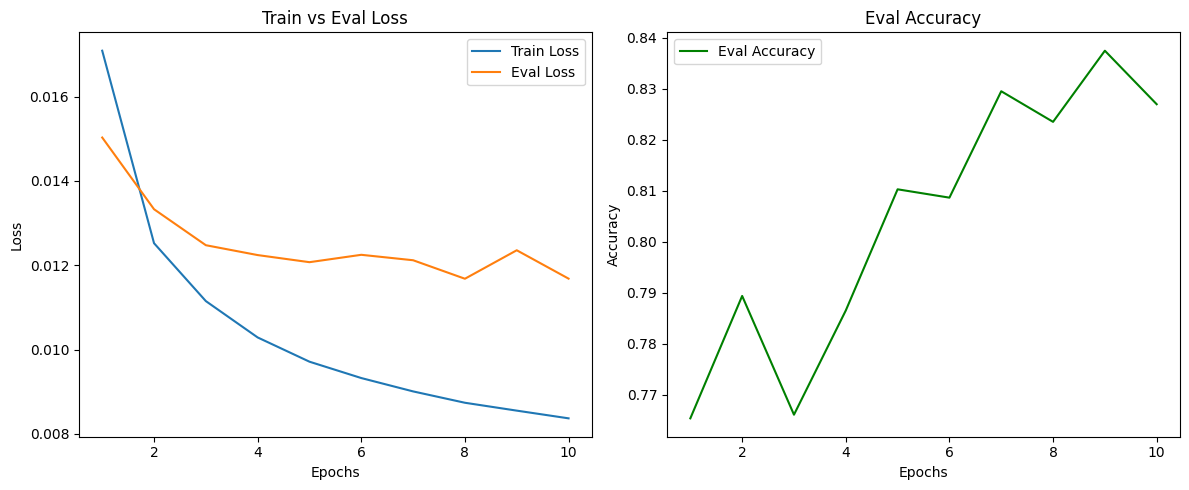

In [ ]:
def plot_metrics(train_losses, eval_losses, eval_accuracies):
    """
    Crea un grafico delle metriche salvate.

    Args:
        train_losses (List[float]): Lista dei loss del training.
        eval_losses (List[float]): Lista dei loss di valutazione.
        eval_accuracies (List[float]): Lista delle accuratezze di valutazione.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot del train loss e eval loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, eval_losses, label="Eval Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Eval Loss")
    plt.legend()

    # Plot dell'eval accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, eval_accuracies, label="Eval Accuracy", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Eval Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, eval_losses, eval_accuracies)

## 7. Rank-1, Rank-5, Rank-10 & mAP(%)

In [68]:
import matplotlib.pyplot as plt
import random
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

def feature_extractor(model, image_path, device):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        image_tensor = preprocess_image(image_path, device)
        features = model.forward_once(image_tensor)
    return features.cpu().numpy().flatten()

def mean_average_precision(results):
    average_precisions = []
    for query_id, sorted_vehicle_ids in results:
        relevant = [1 if vid == query_id else 0 for vid in sorted_vehicle_ids]
        if sum(relevant) == 0:
            continue
        precisions = []
        num_relevant = 0
        for i, rel in enumerate(relevant):
            if rel:
                num_relevant += 1
                precisions.append(num_relevant / (i + 1))
        average_precisions.append(sum(precisions) / sum(relevant))
    return np.mean(average_precisions) if average_precisions else 0

def rank_evaluation(model, dataframe, top_k=10, num_examples=3, device="cuda"):
    model = model.to(device)
    model.eval()
    
    image_paths = dataframe["image_name"].apply(lambda x: f"./data/VeRi/image_test/{x}")
    image_features = {path: feature_extractor(model, path, device) for path in image_paths}
    image_feature_matrix = np.array(list(image_features.values()))
    image_names = list(image_features.keys())
    
    image_to_vehicle = {row["image_name"]: row["vehicle_id"] for _, row in dataframe.iterrows()}
    
    correct_rank1 = 0
    correct_rank5 = 0
    correct_rank10 = 0
    all_results = []
    map_results = []
    
    for query_img in image_names:
        query_feature = image_features[query_img].reshape(1, -1)
        query_id = image_to_vehicle[query_img.split("/")[-1]]
        
        dists = np.linalg.norm(image_feature_matrix - query_feature, axis=1)
        sorted_indices = np.argsort(dists)
        sorted_images = [image_names[i] for i in sorted_indices if image_names[i] != query_img]
        sorted_vehicle_ids = [image_to_vehicle[img.split("/")[-1]] for img in sorted_images]
        sorted_distances = dists[sorted_indices][1:top_k+1]
        
        if query_id == sorted_vehicle_ids[0]:
            correct_rank1 += 1
        if query_id in sorted_vehicle_ids[:5]:
            correct_rank5 += 1
        if query_id in sorted_vehicle_ids[:10]:
            correct_rank10 += 1
        
        map_results.append((query_id, sorted_vehicle_ids))
        all_results.append((query_img, query_id, sorted_images[:top_k], sorted_vehicle_ids[:top_k], sorted_distances))
    
    rank1_accuracy = correct_rank1 / len(dataframe)
    rank5_accuracy = correct_rank5 / len(dataframe)
    rank10_accuracy = correct_rank10 / len(dataframe)
    map_score = mean_average_precision(map_results)
    
    print(f"Rank-1 Accuracy: {rank1_accuracy:.2%}")
    print(f"Rank-5 Accuracy: {rank5_accuracy:.2%}")
    print(f"Rank-10 Accuracy: {rank10_accuracy:.2%}")
    print(f"mAP: {map_score:.2%}")
    
    num_examples = min(num_examples, len(all_results))
    for example in random.sample(all_results, num_examples):
        query_img, query_id, top_matches, top_ids, distances = example
        fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 5))
        
        query_image = plt.imread(query_img)
        axes[0].imshow(query_image)
        axes[0].set_title(f"Query (ID: {query_id})")
        axes[0].axis("off")
        
        for i, (img, vehicle_id, dist) in enumerate(zip(top_matches, top_ids, distances)):
            result_img = plt.imread(img)
            axes[i + 1].imshow(result_img)
            axes[i + 1].set_title(f"ID: {vehicle_id}\nDist: {dist:.4f}")
            axes[i + 1].axis("off")
        
        plt.show()
    
    return rank1_accuracy, rank5_accuracy, rank10_accuracy, map_score


Rank-1 Accuracy: 26.16%
Rank-5 Accuracy: 56.54%
Rank-10 Accuracy: 70.27%
mAP: 14.96%


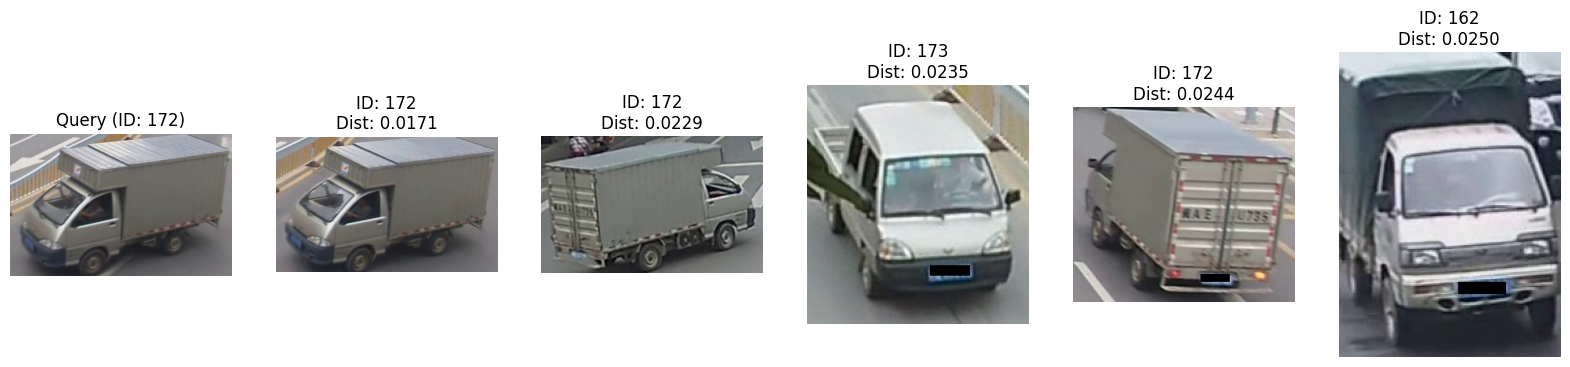

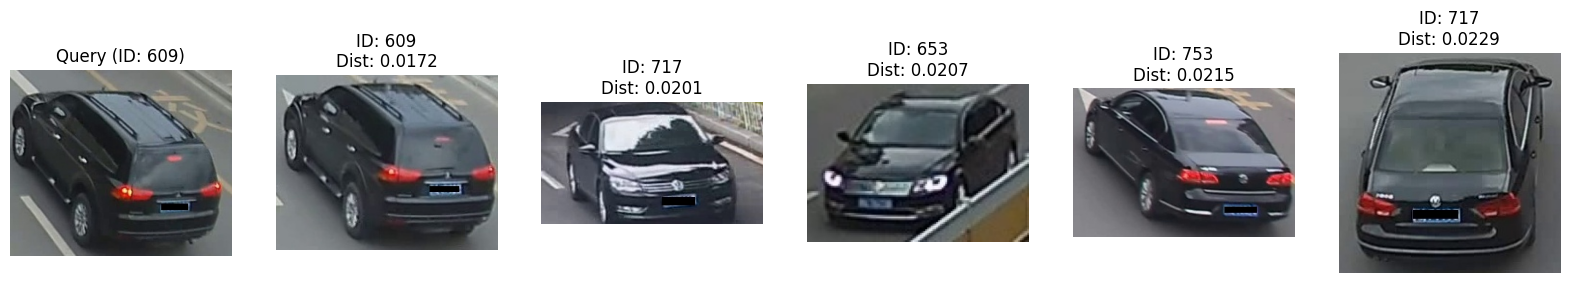

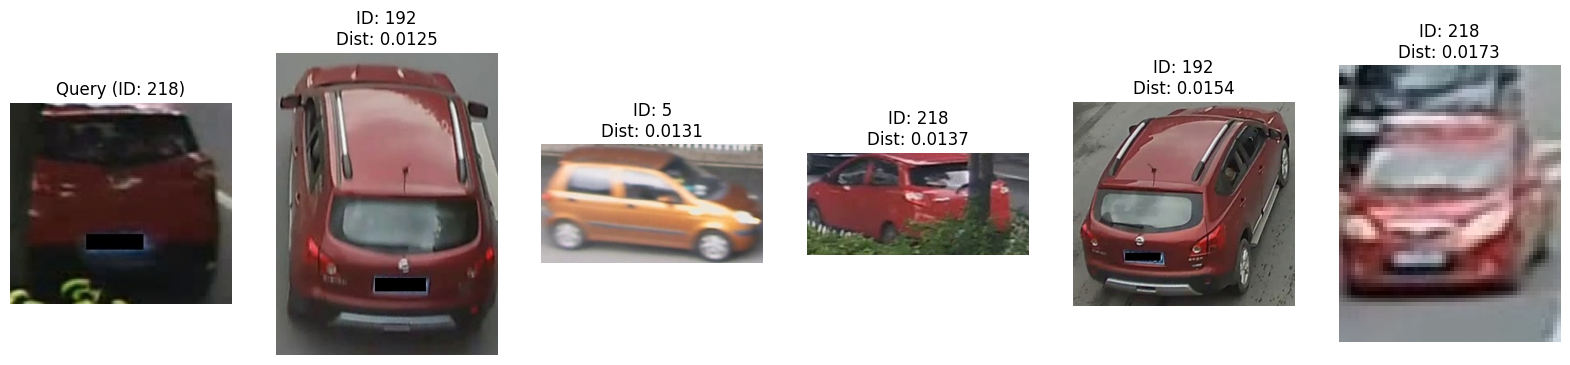

(0.26159426548061143,
 0.5654201571811037,
 0.702737714828569,
 np.float64(0.14964761491639247))

In [69]:
rank_evaluation(model, test_labels_df, top_k=5, num_examples=3)

## 8. Tests

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F

def find_and_visualize_best_match(query_image_path, reference_image_paths, model, transform, device='cpu'):
    """
    Trova l'immagine più simile a una query e visualizza tutte le immagini di riferimento,
    colorando di verde l'immagine più simile.

    Args:
        query_image_path (str): Percorso dell'immagine di query.
        reference_image_paths (list): Lista di percorsi delle immagini di riferimento.
        model (torch.nn.Module): Modello Siamese addestrato.
        transform (callable): Trasformazioni per preprocessare le immagini.
        device (str): Dispositivo per l'elaborazione ('cpu' o 'cuda').

    Returns:
        tuple: (Percorso dell'immagine più simile, distanza minima).
    """
    # Preprocessa l'immagine di query
    query_image = Image.open(query_image_path).convert("RGB")
    query_tensor = transform(query_image).unsqueeze(0).to(device)

    # Inizializza la ricerca
    distances = []

    # Confronta l'immagine di query con ogni immagine di riferimento
    model.eval()
    for ref_path in reference_image_paths:
        ref_image = Image.open(ref_path).convert("RGB")
        ref_tensor = transform(ref_image).unsqueeze(0).to(device)

        with torch.no_grad():
            # Calcola gli embedding usando il forward completo
            query_embedding, ref_embedding = model(query_tensor, ref_tensor)

        # Calcola la distanza tra gli embedding
        distance = F.pairwise_distance(query_embedding, ref_embedding).item()
        distances.append((ref_path, ref_image, distance))

    # Ordina per distanza crescente
    distances.sort(key=lambda x: x[2])
    most_similar_path, most_similar_image, min_distance = distances[0]

    # Visualizzazione
    fig, axes = plt.subplots(1, len(reference_image_paths) + 1, figsize=(15, 5))

    # Immagine di query
    axes[0].imshow(query_image)
    axes[0].axis("off")
    axes[0].set_title("Query Image")

    # Visualizza immagini di riferimento
    for idx, (ref_path, ref_image, distance) in enumerate(distances, start=1):
        axes[idx].imshow(ref_image)
        axes[idx].axis("off")

        # Colore della cornice
        color = "green" if ref_path == most_similar_path else "red"
        axes[idx].set_title(f"Dist: {distance:.4f}", color=color)

    plt.tight_layout()
    plt.show()

    return most_similar_path, min_distance

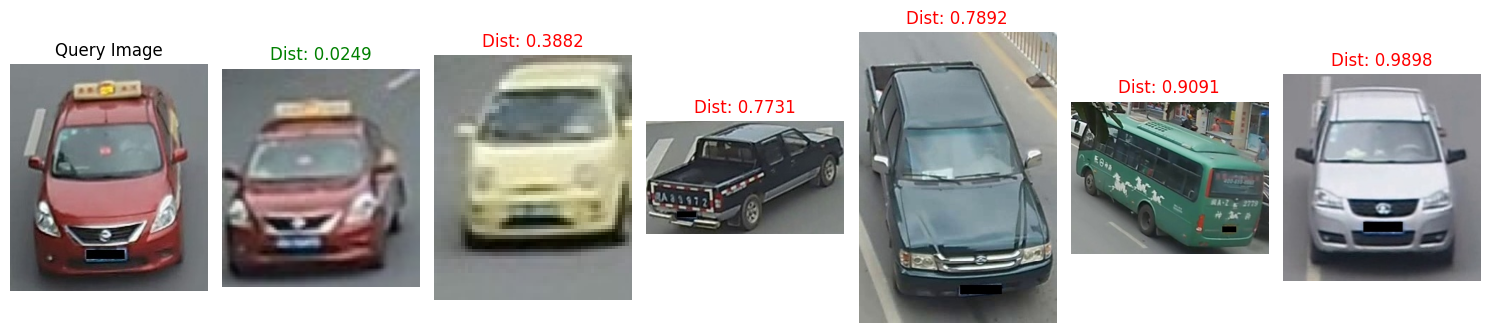

L'immagine più simile è: ./data/VeRi/image_test/0035_c006_00001085_1.jpg con una distanza di: 0.0249


In [71]:
# Percorsi
query_image = "./data/VeRi/image_query/0035_c006_00001150_0.jpg"
reference_images = ["./data/VeRi/image_test/0002_c006_00083490_0.jpg",
                    "./data/VeRi/image_test/0066_c016_00055465_0.jpg",
                    "./data/VeRi/image_test/0035_c006_00001085_1.jpg",
                    "./data/VeRi/image_test/0086_c013_00079890_0.jpg",
                    "./data/VeRi/image_test/0102_c016_00010770_0.jpg",
                    "./data/VeRi/image_test/0101_c001_00043710_0.jpg"]

# Dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# Esegui la ricerca
most_similar_image, distance = find_and_visualize_best_match(query_image, reference_images, model, test_transform, device)

# Risultato
print(f"L'immagine più simile è: {most_similar_image} con una distanza di: {distance:.4f}")

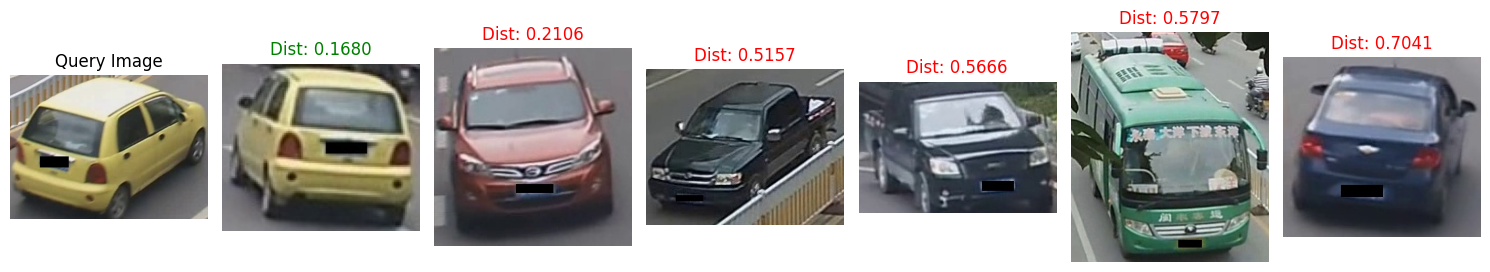

L'immagine più simile è: ./data/VeRi/image_test/0002_c002_00030670_0.jpg con una distanza di: 0.1680


In [72]:
# Percorsi
query_image = "./data/VeRi/image_query/0002_c002_00030600_0.jpg"
reference_images = ["./data/VeRi/image_test/0102_c012_00007875_0.jpg",
                    "./data/VeRi/image_test/0002_c002_00030670_0.jpg",
                    "./data/VeRi/image_test/0006_c019_00024125_0.jpg",
                    "./data/VeRi/image_test/0090_c009_00078235_0.jpg",
                    "./data/VeRi/image_test/0042_c002_00085830_0.jpg",
                    "./data/VeRi/image_test/0065_c016_00068360_0.jpg"]

# Dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# Esegui la ricerca
most_similar_image, distance = find_and_visualize_best_match(query_image, reference_images, model, test_transform, device)

# Risultato
print(f"L'immagine più simile è: {most_similar_image} con una distanza di: {distance:.4f}")


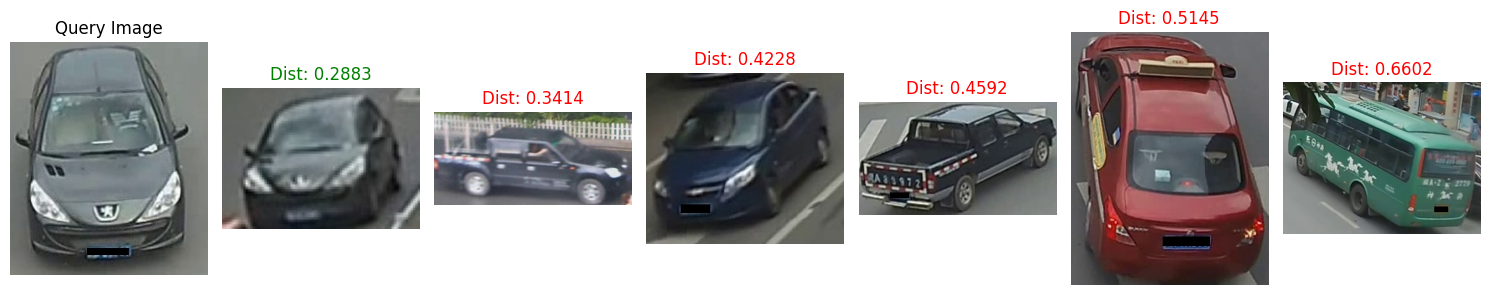

L'immagine più simile è: ./data/VeRi/image_test/0063_c017_00008655_1.jpg
con una distanza di: 0.2883


In [73]:
query_image = "./data/VeRi/image_query/0063_c001_00009565_0.jpg"
reference_images = ["./data/VeRi/image_test/0042_c017_00082800_0.jpg",
                    "./data/VeRi/image_test/0066_c016_00055465_0.jpg",
                    "./data/VeRi/image_test/0035_c003_00001855_0.jpg",
                    "./data/VeRi/image_test/0063_c017_00008655_1.jpg",
                    "./data/VeRi/image_test/0096_c007_00030635_0.jpg",
                    "./data/VeRi/image_test/0101_c001_00043710_0.jpg"]

# Dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# Esegui la ricerca
most_similar_image, distance = find_and_visualize_best_match(query_image, reference_images, model, test_transform, device)

# Risultato
print(f"L'immagine più simile è: {most_similar_image}\ncon una distanza di: {distance:.4f}")